path01.tif
78241.0
total length: 72042.0
pixels in the right place: 3240.0
path02.tif
87540.0
total length: 71327.0
pixels in the right place: 5321.0
path03.tif
57049.0
total length: 39228.0
pixels in the right place: 7206.0
path04.tif
38343.0
total length: 24569.0
pixels in the right place: 8300.0
path05.tif
24131.0
total length: 15717.0
pixels in the right place: 9025.0
path06.tif
19006.0
total length: 13777.0
pixels in the right place: 9557.0
path07.tif
15166.0
total length: 11974.0
pixels in the right place: 9890.0
path08.tif
13456.0
total length: 11491.0
pixels in the right place: 10196.0
path09.tif
12776.0
total length: 11463.0
pixels in the right place: 10277.0
path10.tif
11824.0
total length: 11022.0
pixels in the right place: 10380.0
path11.tif
11564.0
total length: 11045.0
pixels in the right place: 10362.0
path12.tif
11231.0
total length: 10960.0
pixels in the right place: 10456.0
path13.tif
11272.0
total length: 10923.0
pixels in the right place: 10477.0
path14.tif
11113.0


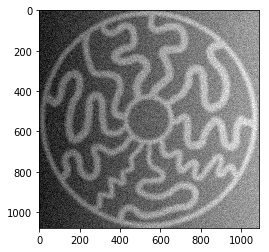

In [687]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.morphology import skeletonize, remove_small_objects
##creating a circular mask so any stuff outside the circle will be disregarded   
z = np.zeros((1078,1088))
# specify circle parameters: centre ij and radius
ci,cj=540,539
cr=539
# Create index arrays to z
I,J=np.meshgrid(np.arange(z.shape[0]),np.arange(z.shape[1]))
# calculate distance of all points to centre
dist=np.sqrt((I-ci)**2+(J-cj)**2)
# Assign value of 1 to those points where dist<cr:
z[np.where(dist<cr)]=1

output = np.zeros((25,2))

for i in range(25):
    fname = "path%02d.tif" % (1+i)
    print(fname)
    
    original_img = cv2.imread(fname,0)

    (h,w)=np.shape(original_img)
    img = original_img[0:h, 0:w]
    #plt.imshow(img, cmap = 'gray')
    #equalizing the histogram
    equ = cv2.equalizeHist(img)
    
     #This sction blurs, thresholds, and skeletonizes the image
    #It uses an average blur and an adaptive (local) mean threshold
    #Remove_small_objects gets rid of any unconnected dots or lines
    ablur = cv2.blur(equ,(17, 17))
    a_mthres = cv2.adaptiveThreshold(ablur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,171,4) 
    adaptiveskeleton = skeletonize(a_mthres)
    clskel=remove_small_objects(adaptiveskeleton, min_size=250, connectivity=3)
    cleanskel=clskel*z

    #the original image values (integers) become floats
    #Dividing by 255 normalizes the floats; now they are all between 0 and 1
    floatimg=img.astype(float)
    normimg=floatimg/255

    #skeleton is a float, rgbpic is a RGB image with the dimensions of the cropped diatom image
    #the values of R,G, and B are defined later
    floatskel=cleanskel.astype(float)
    (x,y)=np.shape(img)
    rgbpic=np.zeros((x,y,3))
    
     # this section finds the number of neighbors to each point in the skeleton
    # line ends are points that have only one neighbor
    # we want to get rid of these
    # keep looping over this section until the number of line ends equals zero
    nLineEnds = 1
    while (nLineEnds>0):
        #blur the skeleton with 3x3; this gives the average value in a 3x3 portion of the skeleton
        # 9 times the average - 1 should be the number of neighbors
        skelblur = cv2.blur(floatskel,(3,3))
        neighbors=((9*skelblur)-1)

        #making sure edges always have values
        #any skeleton pixels within 'a' pixels from the edge will not be eroded
        edges=np.zeros((x,y))
        a=15
        edges[0:a,:]=np.ones((a,y))
        edges[x-a:x,:]=np.ones((a,y))
        edges[:,0:a]=np.ones((x,a))
        edges[:,y-a:y]=np.ones((x,a))

        #removing the end pixel if a skeleton pixel has 1 neighbor
        neighbors=(neighbors+5*edges)*floatskel
        line_ends = (neighbors==1)
        float_line_ends = line_ends.astype(float)
        floatskel=floatskel-line_ends
        nLineEnds=np.sum(line_ends)
    #plt.imshow(neighbors, interpolation='sinc')
    
    #reading in the dilated correct skeleton to assess su
    correctskeleton=cv2.imread("dilation3.tif", 0)

    # total length of skeleton
    #print("total length:", np.sum(floatskel))
    
    #for the number of pixels in the right place
    #print("pixels in the right place:", np.sum(correctskeleton*floatskel))
    
    output[i,0] = np.sum(floatskel)
    output[i,1] = np.sum(correctskeleton*floatskel)
    
print(output)
    

In [679]:
    #This sction blurs, thresholds, and skeletonizes the image
    #It uses an average blur and an adaptive (local) mean threshold
    #Remove_small_objects gets rid of any unconnected dots or lines
    ablur = cv2.blur(equ,(17, 17))
    a_mthres = cv2.adaptiveThreshold(ablur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,171,4) 
    adaptiveskeleton = skeletonize(a_mthres)
    clskel=remove_small_objects(adaptiveskeleton, min_size=250, connectivity=3)
    cleanskel=clskel*z

    #the original image values (integers) become floats
    #Dividing by 255 normalizes the floats; now they are all between 0 and 1
    floatimg=img.astype(float)
    normimg=floatimg/255

    #skeleton is a float, rgbpic is a RGB image with the dimensions of the cropped diatom image
    #the values of R,G, and B are defined later
    floatskel=cleanskel.astype(float)
    (x,y)=np.shape(img)
    rgbpic=np.zeros((x,y,3))
    print(np.sum(floatskel))

10803.0


In [680]:
    # this section finds the number of neighbors to each point in the skeleton
    # line ends are points that have only one neighbor
    # we want to get rid of these
    # keep looping over this section until the number of line ends equals zero
    nLineEnds = 1
    while (nLineEnds>0):
        #blur the skeleton with 3x3; this gives the average value in a 3x3 portion of the skeleton
        # 9 times the average - 1 should be the number of neighbors
        skelblur = cv2.blur(floatskel,(3,3))
        neighbors=((9*skelblur)-1)

        #making sure edges always have values
        #any skeleton pixels within 'a' pixels from the edge will not be eroded
        edges=np.zeros((x,y))
        a=15
        edges[0:a,:]=np.ones((a,y))
        edges[x-a:x,:]=np.ones((a,y))
        edges[:,0:a]=np.ones((x,a))
        edges[:,y-a:y]=np.ones((x,a))

        #removing the end pixel if a skeleton pixel has 1 neighbor
        neighbors=(neighbors+5*edges)*floatskel
        line_ends = (neighbors==1)
        float_line_ends = line_ends.astype(float)
        floatskel=floatskel-line_ends
        nLineEnds=np.sum(line_ends)
    #plt.imshow(neighbors, interpolation='sinc')

In [681]:
    #dilating the lines of the skeleton to a 3x3 square of pixels (lines are bolder)
    #kernel=np.ones((3,3))
    #skel_dilation=cv2.dilate(floatskel,kernel,iterations=1)

    #defining r, g, and b values for the overlay 
    #if the skeleton is 1, then it plots the skeleton.
    #if the skeleton is 0, it plots the grayscale image of the diatom
    #rgbpic[:,:,0]=skel_dilation*(1-normimg)+normimg
    #rgbpic[:,:,1]=(1-skel_dilation)*normimg
    #rgbpic[:,:,2]=(1-skel_dilation)*normimg

    #plotting the overlay
    #plt.imshow(rgbpic, interpolation='sinc')

In [682]:
    #reading in the dilated correct skeleton to assess su
    correctskeleton=cv2.imread("dilation3.tif", 0)

    # total length of skeleton
    print("total length:", np.sum(floatskel))
    
    #for the number of pixels in the right place
    print("pixels in the right place:", np.sum(correctskeleton*floatskel))
    
    output[i,0] = np.sum(floatskel)
    output[i,1] = np.sum(correctskeleton*floatskel)
    

total length: 10780.0
pixels in the right place: 10677.0


In [683]:
print(output)

[[    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [    0.     0.]
 [10780. 10677.]]


In [684]:
output2=np.zeros((5,2))
for i in range(5):
    output2[i,0] = 1;
    output2[i,1] = i;



In [685]:
a = 2;
b = 3;
print(a*b)

6


In [686]:
print(output2)

[[1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]]
